<a href="https://colab.research.google.com/github/petrovortex/dls-homework-sem-2/blob/main/agentic_system_project_%5Bpublic%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO-DO:
1. (done) Implement search functionality in the BestAgent class.
2. (done) Update instructions and output format for the draft (so it will generate a question for Tavily).
3. (done) Make the report in run_evaluation more informative.
4. Analyze whether adopting agentic frameworks improves code modularity and flexibility compared to the current implementation.

## README

This notebook implements an **Agentic AI system** designed to estimate the **relevance of Map POIs** (Points of Interest) to user queries using Large Language Models.

---

**Input Data:** Training (35k rows) and validation (570 rows) datasets containing:
1. User Query `Text`: The raw search request.
2. POI Attributes (6 cols): metadata including `name`, `address`, and other descriptions.
3. Ground Truth: The `relevance` score of the POI to the query.

---

**Base Solution:**

The baseline approach utilizes a direct, **single-pass LLM call** with a generic **Zero-shot prompt** (e.g., *'Determine the relevance of {object} to {query}'*). This serves as a benchmark for performance without agentic capabilities.

---

**Best Solution:**

To overcome the limitations of the baseline, the following architectural improvements were implemented:

1.  **Advanced Prompt Engineering:** Implementation of structured instructions (System Prompt) with specific meta-rules for handling most common types of mistakes.
2.  **RAG System (Knowledge Base):** Construction of a vector-based Knowledge Base from the training dataset to enable **Dynamic Few-Shot Prompting**. This allows the model to take into account labeling patterns from similar historical cases.
3.  **Reflection Pattern:** Integration of a secondary "Critic" model to audit draft responses. Includes conditional logic to trigger the Critic only when necessary.
4.  **External Search Tool:** Incorporation of web search capabilities to fetch missing context for ambiguous entities.

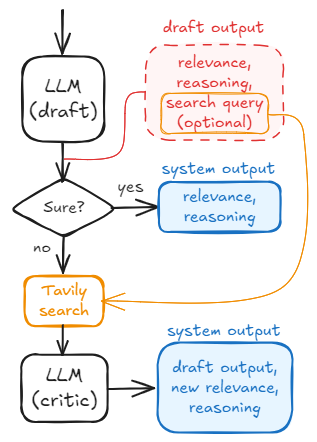

## 0. Data loading

In [ ]:
!pip install -q pandas openai pydantic requests tqdm litellm opik scikit-learn sentence-transformers faiss-cpu tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.1 MB/s eta 0:00:00


In [ ]:
import requests
from urllib.parse import urlencode
import pandas as pd
import io

from sklearn.model_selection import train_test_split

def download_file_from_yadisk(public_key: str):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)
    return io.BytesIO(download_response.content)

TEST_PUBLIC_LINK = "https://disk.360.yandex.ru/d/aCpPMD--Yi_y5g"
TRAIN_PUBLIC_LINK = "https://disk.360.yandex.ru/d/Y4HNAcJh6_cNog"

try:
    test_file_content = download_file_from_yadisk(TEST_PUBLIC_LINK)
    train_file_content = download_file_from_yadisk(TRAIN_PUBLIC_LINK)

    df_test = pd.read_json(test_file_content, lines=True)
    df_train = pd.read_json(train_file_content, lines=True)

    print(f"Test dataset loaded. Shape: {df_test.shape}")
    print(f"Train dataset loaded. Shape: {df_train.shape}")
    print("Columns test:", df_test.columns.tolist())
    print("Columns train:", df_train.columns.tolist())
except Exception as e:
    print(f"Ошибка загрузки: {e}")

Test dataset loaded. Shape: (570, 9)
Train dataset loaded. Shape: (35094, 9)
Columns test: ['Text', 'address', 'name', 'normalized_main_rubric_name_ru', 'permalink', 'prices_summarized', 'relevance', 'reviews_summarized', 'relevance_new']
Columns train: ['Text', 'address', 'name', 'normalized_main_rubric_name_ru', 'permalink', 'prices_summarized', 'relevance', 'reviews_summarized', 'relevance_new']


In [ ]:
df_kb, df_val = train_test_split(df_train, test_size=0.05, random_state=42, stratify=df_train['relevance_new'])

## 1. Imports and configs

In [ ]:
import os
import json
from typing import List, Optional, Dict, Any

import pickle
import numpy as np
import faiss
import torch
from sentence_transformers import SentenceTransformer

import litellm
from litellm import Router
from pydantic import BaseModel, Field, ValidationError, field_validator

from opik import track
from opik.opik_context import get_current_span_data, update_current_span
from litellm.integrations.opik.opik import OpikLogger

from tavily import TavilyClient

from sklearn.metrics import accuracy_score, classification_report

os.environ["OPIK_API_KEY"] = "..."
os.environ["OPIK_WORKSPACE"] = "default"
os.environ["TAVILY_API_KEY"] = "tvly-dev-..."

opik_logger = OpikLogger()

tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

API_KEYS = [
    "sk-or-v1-...",
    "sk-or-v1-...",
    "sk-or-v1-...",
    "sk-or-v1-...",
    "sk-or-v1-...",
    "sk-or-v1-...",
    "sk-or-v1-..."
]

MODELS_CONFIG = {
    "mimo-v2-flash": "openrouter/xiaomi/mimo-v2-flash:free",
    "gpt-oss-120b": "openrouter/openai/gpt-oss-120b:free",
    "glm-4.5-air": "openrouter/z-ai/glm-4.5-air:free",
    "kimi": "openrouter/moonshotai/kimi-k2:free",
    "deepseek-r1": "openrouter/deepseek/deepseek-r1-0528:free"
}

model_list = []

for alias, model_id in MODELS_CONFIG.items():
    for key in API_KEYS:
        model_list.append({
            "model_name": alias,
            "litellm_params": {
                "model": model_id,
                "api_key": key
            }
        })

llm_router = Router(
    model_list=model_list,
    routing_strategy="simple-shuffle",
    timeout=30,
    num_retries=2,
    allowed_fails=3,
    cooldown_time=60,
)

class BaseResult(BaseModel):
    reasoning: str = Field(description="Detailed Step-by-step thinking process.")
    score: float = Field(description="Relevance score: must be exactly 0.0, 0.1, or 1.0")

    @field_validator('score')
    @classmethod
    def snap_to_grid(cls, v: int) -> float:
        allowed = [0.0, 0.1, 1.0]
        closest = min(allowed, key=lambda x: abs(x - v))
        return closest

class DraftDecision(BaseModel):
    reasoning: str = Field(description="Analysis of the current information")
    needs_search: bool = Field(description="Set to True if critical information is missing")
    search_query: Optional[str] = Field(description="Specific search query if needs_search is True", default=None)
    preliminary_score: float = Field(description="Score if no search is needed", default=None)

    @field_validator('preliminary_score')
    @classmethod
    def snap_score(cls, v: Optional[float]) -> Optional[float]:
        if v is None: return None
        allowed = [0.0, 0.1, 1.0]
        return min(allowed, key=lambda x: abs(x - v))

class FinalVerdict(BaseModel):
    reasoning: str = Field(description="Final detailed reasoning")
    score: float = Field(description="Final score: 0.0, 0.1, or 1.0")

    @field_validator('score')
    @classmethod
    def snap_score(cls, v: float) -> float:
        allowed = [0.0, 0.1, 1.0]
        return min(allowed, key=lambda x: abs(x - v))

def format_input_context(row: pd.Series) -> str:
    return f"""
USER QUERY: "{row['Text']}"

OBJECT DETAILS:
- Name: {row['name']}
- Rubric: {row['normalized_main_rubric_name_ru']}
- Address: {row['address']}
- Prices: {row['prices_summarized'] if pd.notna(row['prices_summarized']) else "No data"}
- Reviews: {row['reviews_summarized'] if pd.notna(row['reviews_summarized']) else "No data"}
"""

## 2. Base solution

In [ ]:
def get_base_system_prompt():
    return """
Determine the relevance of OBJECT to USER QUERY.

VALID OUTPUT VALUES:
- 1.0: Relevant. The object provides what the user wants.
- 0.0: Irrelevant.
- 0.1: Partial/Unsure.

Output strictly JSON: {"score": float}
"""

def get_base_user_prompt(context):
    return f"Analyze this case: {context}"

In [ ]:
class BaseAgent:
    def __init__(self, router: Router, model_alias: str):
        self.router = router
        self.model_alias = model_alias

    def _call_llm(self, messages: List[Dict[str, str]]) -> BaseResult:
        try:
            response = self.router.completion(
                model=self.model_alias,
                messages=messages,
                response_format={"type": "json_object"},
            )
            content = response.choices[0].message.content
            return BaseResult.model_validate_json(content)

        except (ValidationError, json.JSONDecodeError):
            return BaseResult(reasoning="Parsing Error", score=0.0)

        except Exception as e:
            print(f"LLM Call Error: {e}")
            return BaseResult(reasoning="API Error", score=0.0)

    @track(name="baseline relevance_prediction")
    def predict(self, row: pd.Series) -> float:
        context = format_input_context(row)

        system_prompt = get_base_system_prompt()
        user_prompt = get_base_user_prompt(context)

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]

        result = self._call_llm(messages)

        return result.score

In [ ]:
def run_base_evaluation(agent, dataset, limit = 50):
    sample_df = dataset.sample(n=min(limit, len(dataset)), random_state=42).copy()
    y_true = sample_df['relevance_new'].tolist()
    y_pred = []

    print(f"Starting evaluation on {len(sample_df)} samples...")

    for _, row in sample_df.iterrows():
        prediction = agent.predict(row)
        y_pred.append(prediction)

    sample_df['predicted_relevance'] = y_pred

    y_true = [str(val) for val in y_true]
    y_pred = [str(val) for val in y_pred]

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, zero_division=0)

    print(f"\nEvaluation Complete.")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

    return sample_df

In [ ]:
print("--- Testing mimo-v2-flash ---")
agent_mimo_base = BaseAgent(llm_router, model_alias="mimo-v2-flash")
df_mimo_base = run_base_evaluation(agent_mimo_base, df_val, limit=30)

## 3. Best solution

### 3.1 Knowledge Base

In [ ]:
class KnowledgeBase:
    def __init__(self, dataframe, model_name='intfloat/multilingual-e5-large', index_path="kb_index"):
        self.df = dataframe.reset_index(drop=True)
        self.model_name = model_name
        self.index_path_faiss = f"{index_path}.faiss"
        self.index_path_meta = f"{index_path}.pkl"

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Loading embedding model on {self.device}...")
        self.model = SentenceTransformer(model_name, device=self.device)

        self.index = None

        if os.path.exists(self.index_path_faiss) and os.path.exists(self.index_path_meta):
            self.load()
        else:
            self.build_index()

    def _row_to_text(self, row, is_query):
        prefix = "query: " if is_query else "passage: "
        content = f"User request: {row['Text']} | Name: {row['name']} | Address: {row['address']} | Rubric: {row['normalized_main_rubric_name_ru']}"
        return prefix + content

    def build_index(self, batch_size=64):
        print("Building Vector Index...")
        sentences = self.df.apply(lambda x: self._row_to_text(x, is_query=False), axis=1).tolist()

        embeddings = self.model.encode(
            sentences,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True
        )

        d = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(d)
        self.index.add(embeddings)

        print(f"Index built. Vectors: {self.index.ntotal}")
        self.save()

    @track(name="vector_search")
    def search(self, row, k=3):
        query_text = self._row_to_text(row, is_query=True)
        query_vec = self.model.encode([query_text], convert_to_numpy=True, normalize_embeddings=True)

        distances, indices = self.index.search(query_vec, k + 1)

        results = []
        for i, idx in enumerate(indices[0]):
            if i >= k: break

            match_row = self.df.iloc[idx]

            results.append({
                "text": match_row['Text'],
                "name": match_row['name'],
                "relevance": match_row['relevance'],
                "distance": float(distances[0][i])
            })
        return results

    def save(self):
        faiss.write_index(self.index, self.index_path_faiss)
        with open(self.index_path_meta, "wb") as f:
            pickle.dump(self.df, f)

    def load(self):
        self.index = faiss.read_index(self.index_path_faiss)
        with open(self.index_path_meta, "rb") as f:
            self.df = pickle.load(f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_folder = "/content/drive/MyDrive/YandexMaps_Agent_Project"
os.makedirs(drive_folder, exist_ok=True)

Mounted at /content/drive


In [ ]:
index_path_drive = os.path.join(drive_folder, "kb_index")
kb = KnowledgeBase(df_kb, index_path=index_path_drive)

Loading embedding model on cpu...


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

### 3.2 Prompts

In [ ]:
def get_system_prompt(is_draft=True) -> str:
    specific_instructions = ''
    if is_draft:
        specific_instructions = """
5. **UNCERTAINTY & SEARCH:**
   - If your analysis leads to a **0.1** score, you MUST set `needs_search` to `true`.
   - Formulate a specific `search_query` intended to find exactly that missing piece of info (e.g., "Menu of Cafe Name, address (short)", "Does Gym X have a pool").
   - If the score is definitively 0.0 or 1.0 based on current data, set `needs_search` to `false`.

6. **OUTPUT FORMAT:** Return strictly JSON with the following keys:
   - `"reasoning"`: (string) step-by-step analysis.
   - `"needs_search"`: (boolean)
   - `"search_query"`: (string or null)
   - `"preliminary_score"`: (float) 0.0, 0.1, or 1.0
"""
    else:
        specific_instructions = """
5. **OUTPUT FORMAT:** Return strictly JSON with the following keys:
   - `"reasoning"`: (string) Final verdict explanation, incorporating search results if available.
   - `"score"`: (float) Final relevance score: exactly 0.0, 0.1, or 1.0.
"""
    return f"""
You are a search relevance expert. Your goal is to assess if a map object satisfies a user query.

VALID OUTPUT VALUES:
- 1.0: Perfect match. The object definitely provides what the user wants.
- 0.0: Irrelevant. Wrong category, closed, or completely unrelated.
- 0.1: Partial/Unsure. The object might be relevant, but specific IMPORTANT (think about importance) constraints (if they are) from user (price, specific service) are not explicitly confirmed in the object details.

IMPORTANT: HANDLING HISTORICAL EXAMPLES
You will be provided with "SIMILAR HISTORICAL CASES" from the training database.
1. Use them to understand the *labeling logic* (e.g., how strict the rules are regarding location or category).
2. WARNING: The historical labels might be noisy or based on info not visible in the card (e.g., the place was permanently closed at that time).
3. If a historical example contradicts common sense (e.g., perfect match labeled 0.0), prioritize your own analysis of the current object's data.

INSTRUCTIONS:
1. Think step-by-step. Detect the USER INTENT: Is the user looking for a specific **ITEM/SERVICE** (e.g., "buy pills", "sauna") or a specific **VENUE TYPE** (e.g., "Pharmacy", "Recreation Base")?
2. **IF USER WANTS A VENUE TYPE (Category Search):**
   - **RUBRIC PRIORITY:** The object's `Rubric` must semantically match the requested venue type.
   - **MISMATCH PENALTY:** If the user asks for "Category A" (e.g., "Holiday Center") and the object is "Category B" (e.g., "Sports Camp"), the score is likely **0.0**, even if they share some features (like saunas or beds).
   - *Exception:* Only give 0.1 or 1.0 if Category B is a direct sub-type or synonym of Category A.
3. **IF USER WANTS AN ITEM/SERVICE:**
   - **CATEGORY LOGIC:** If the user asks for a COMMON item (e.g., "aspirin") and the object is a standard provider (Pharmacy), **SCORE IS 1.0**.
   - **PARTIAL INVENTORY (The "Open List" Rule):**
     - Treat 'Prices' and 'Description' as **incomplete examples**, not a full catalog.
     - If the object sells "Bags" but lists only "Wallets", assume it MIGHT sell "Suitcases".
     - **DO NOT DOWNGRADE TO 0.0** just because a specific item or brand is missing from the text description, unless the category makes it impossible (e.g., asking for "Suitcase" in a "Bakery").
     - **Verdict:** If Category matches but Item/Brand is unconfirmed -> Score is **0.1**.
   - Use 0.1 for RARE/SPECIFIC items where availability is truly unknown.
4. Pay attention to "Hard Constraints" (open now, free wifi) in user request.
{specific_instructions}
"""

def format_rag_context(examples: list) -> str:
    if not examples:
        return "No similar examples found."

    text = ""
    for i, ex in enumerate(examples):
        text += f"""
[Example {i+1}]
User Query: "{ex['text']}"
Object Name: "{ex['name']}"
Ground Truth Relevance: {ex['relevance']}
(Similarity Score: {ex['distance']:.2f})
"""
    return text

def get_draft_prompt(context: str, rag_text: str):
    return f"""
Analyze this case:
{context}

---
SIMILAR HISTORICAL CASES (For Reference):
{rag_text}
---
"""

def get_critique_prompt(context: str, rag_text: str, search_results: str) -> str:
    return f"""
Analyze this case:
{context}

HISTORICAL REFERENCES (For Reference):
{rag_text}

EXTERNAL EVIDENCE FROM WEB SEARCH (For Reference):
{search_results}
"""

### 3.3 Best agent class

In [ ]:
class BestAgent:
    def __init__(self, router: Router, model_alias: str, kb: KnowledgeBase):
        self.router = router
        self.model_alias = model_alias
        self.kb = kb

    @track
    def _call_llm(self, messages: List[Dict[str, str]], response_model: Any, step_name: str):
        update_current_span(name=step_name)

        try:
            response = self.router.completion(
                model=self.model_alias,
                messages=messages,
                response_format={"type": "json_object"},
            )
            content = response.choices[0].message.content
            return response_model.model_validate_json(content)

        except Exception as e:
            print(f"LLM Call Error in {step_name}: {e}")
            if response_model == DraftDecision:
                return DraftDecision(reasoning="Error", needs_search=False, preliminary_score=0.1)
            return FinalVerdict(reasoning="Error", score=0.0)

    @track(name="tavily_search_execution")
    def _execute_search(self, query: str) -> str:
        try:
            response = tavily_client.search(query, search_depth="basic", max_results=2)
            snippets = [r['content'] for r in response.get('results', [])]
            return "\n".join(snippets)
        except Exception as e:
            return f"Search failed: {e}"

    @track(name="relevance_prediction")
    def predict(self, row: pd.Series) -> float:
        rag_examples = self.kb.search(row, k=3)
        rag_text = format_rag_context(rag_examples)

        context = format_input_context(row)
        system_prompt_draft = get_system_prompt(is_draft=True)

        draft_prompt = get_draft_prompt(context, rag_text)

        draft_messages = [
            {"role": "system", "content": system_prompt_draft},
            {"role": "user", "content": draft_prompt}
        ]

        draft_result = self._call_llm(draft_messages, DraftDecision, step_name="generate_draft")

        trace_log = {
            "needs_search": draft_result.needs_search,
            "search_query": draft_result.search_query,
            "draft_score": draft_result.preliminary_score,
            "draft_reasoning": draft_result.reasoning,
            "search_results": None,
            "final_score": None,
            "final_reasoning": None
        }

        if draft_result.needs_search and draft_result.search_query:
            search_results = self._execute_search(draft_result.search_query)
            trace_log["search_results"] = search_results

            critique_prompt_text = get_critique_prompt(context, rag_text, search_results)

            critic_messages = [
                {"role": "system", "content": get_system_prompt(is_draft=False)},
                {"role": "user", "content": critique_prompt_text}
            ]

            critic_decision = self._call_llm(critic_messages, FinalVerdict, step_name="critique_verification")

            trace_log["final_score"] = critic_decision.score
            trace_log["final_reasoning"] = critic_decision.reasoning

        else:
            score = draft_result.preliminary_score
            trace_log["final_score"] = score
            trace_log["final_reasoning"] = draft_result.reasoning

        return trace_log


### 3.4 Best agent evaluation


In [ ]:
def run_evaluation(agent, dataset, limit=50):
    sample_df = dataset.sample(n=min(limit, len(dataset)), random_state=42).copy()

    final_preds = []
    draft_preds = []
    did_search_list = []
    final_reasonings = []
    draft_reasonings = []

    print(f"Starting evaluation on {len(sample_df)} samples...")

    for _, row in sample_df.iterrows():
        trace = agent.predict(row)

        f_score = trace.get("final_score")
        if f_score is None: f_score = 0.0
        final_preds.append(f_score)

        d_score = trace.get("draft_score")
        if d_score is None: d_score = 0.0
        draft_preds.append(d_score)

        did_search_list.append(trace.get("needs_search", False))
        final_reasonings.append(trace.get("final_reasoning", ""))
        draft_reasonings.append(trace.get("draft_reasoning", ""))

    sample_df['draft_prediction'] = draft_preds
    sample_df['predicted_relevance'] = final_preds
    sample_df['did_search'] = did_search_list
    sample_df['draft_reasoning'] = draft_reasonings
    sample_df['final_reasoning'] = final_reasonings

    y_true_str = sample_df['relevance_new'].astype(float).astype(str).tolist()
    y_pred_final_str = [str(float(x)) for x in final_preds]

    acc = accuracy_score(y_true_str, y_pred_final_str)
    search_rate = np.mean(did_search_list)

    print(f"\nEvaluation Complete.")
    print(f"Accuracy: {acc:.4f}")
    print(f"Search Rate: {search_rate:.1%}")
    print("Classification Report (Final):")
    print(classification_report(y_true_str, y_pred_final_str, zero_division=0))

    cols_to_show = [
        'Text', 'name', 'address',
        'relevance_new',
        'draft_prediction',
        'predicted_relevance',
        'did_search'
    ]

    display_df = sample_df[cols_to_show].copy()

    def highlight_predictions(row):
        gt = float(row['relevance_new'])
        draft = float(row['draft_prediction'])
        final = float(row['predicted_relevance'])

        styles = [''] * len(row)

        idx_draft = row.index.get_loc('draft_prediction')
        idx_final = row.index.get_loc('predicted_relevance')

        green_style = 'background-color: #d4edda; color: #155724'
        red_style = 'background-color: #f8d7da; color: #721c24'

        styles[idx_draft] = green_style if draft == gt else red_style
        styles[idx_final] = green_style if final == gt else red_style

        return styles

    return display_df.style.apply(highlight_predictions, axis=1)

In [ ]:
# Эксперимент 1: Тестируем mimo-v2-flash
print("--- Testing mimo-v2-flash ---")
agent_mimo = BestAgent(llm_router, model_alias="mimo-v2-flash", kb=kb)
df_mimo = run_evaluation(agent_mimo, df_val, limit=30)
df_mimo

In [ ]:
# Эксперимент 2: Тестируем glm-4.5-air
print("\n--- Testing glm-4.5-air ---")
agent_glm = BestAgent(llm_router, model_alias="glm-4.5-air", kb=kb)
df_glm = run_evaluation(agent_glm, df_val, limit=30)
df_glm

In [ ]:
# Эксперимент 3: Тестируем deepseek-r1
print("\n--- Testing deepseek-r1 ---")
agent_deepseek = BestAgent(llm_router, model_alias="deepseek-r1", kb=kb)
df_deepseek = run_evaluation(agent_deepseek, df_val, limit=30)
df_deepseek